In [1]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm

from utils import *
from help import *

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


In [2]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [5]:
import os
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
feta = pathlib.Path("/cbica/home/dadashkj/SynthSeg/data/training_label_maps")

In [7]:
feta_files = list(feta.glob('*.nii.gz'))
brain_maps = [np.uint8(sf.load_volume(str(file_path)).resize(1.5).reshape([param_3d.img_size_24,]*3).data) for file_path in feta_files]

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no

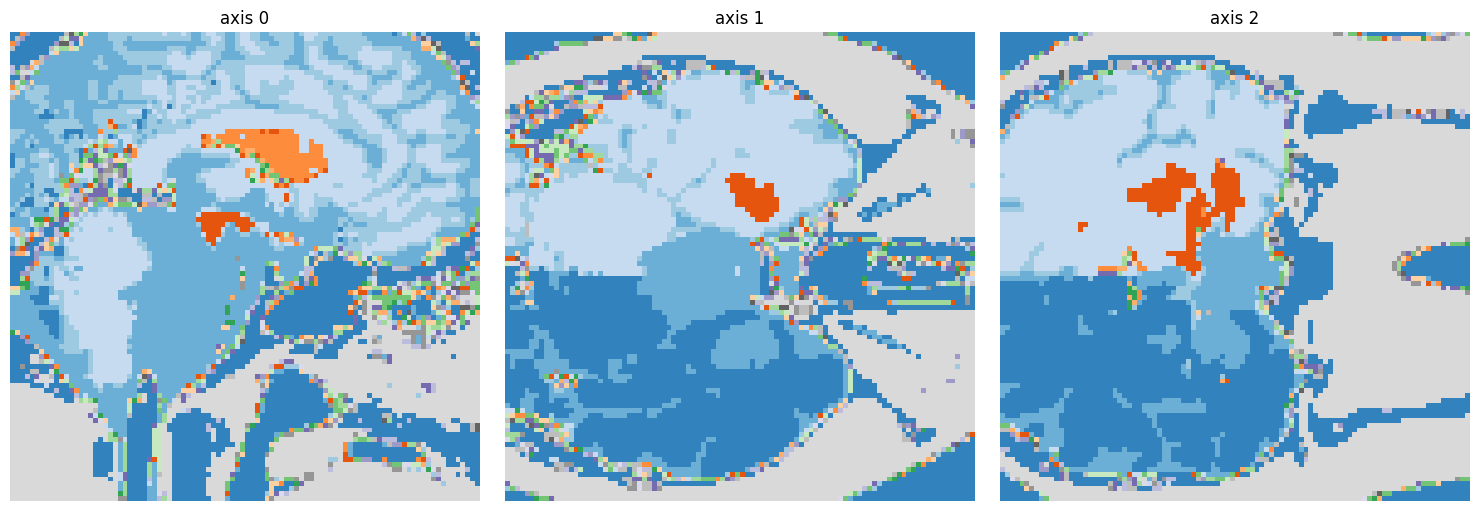

In [8]:
a = brain_maps[0]
ne.plot.volume3D(a,cmaps=['tab20c']);

[DEBUG] NiftiArrayIO.load(): no header extensions found!


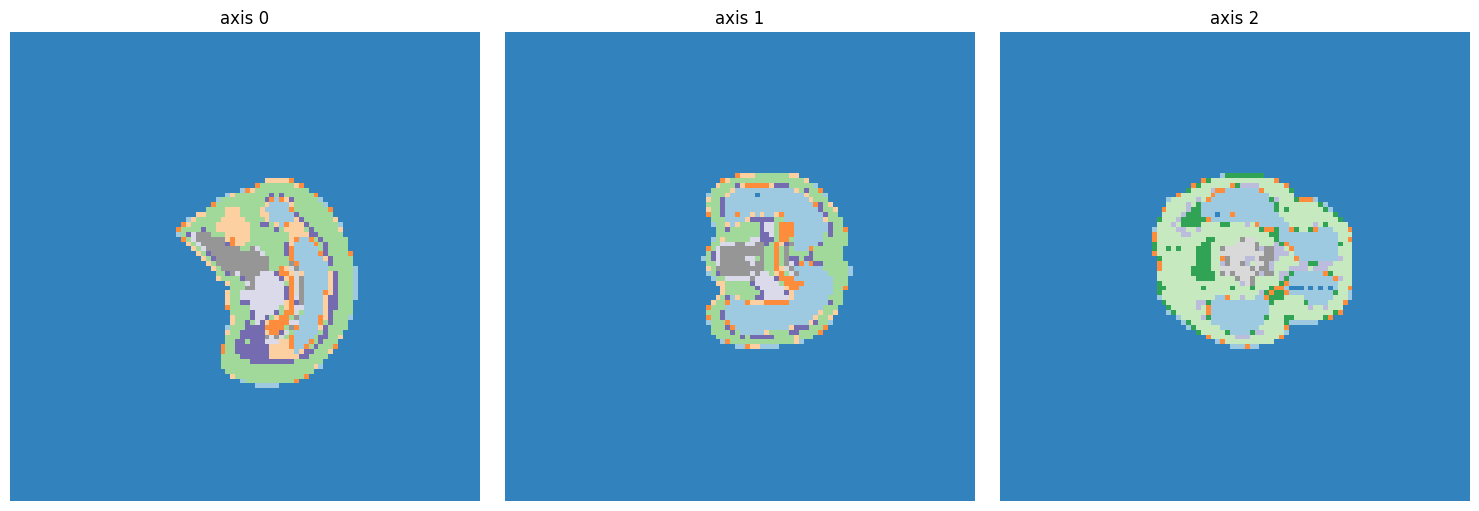

In [9]:
path = "/cbica/home/dadashkj/fetal_brain_atlases/Neurotypical_Gholipour2017/HarvardSTA21_Study1/parcellation.nii.gz"
a = np.uint8(sf.load_volume(str(path)).resize(1.5).reshape([param_3d.img_size_24,]*3).data)
ne.plot.volume3D(a,cmaps=['tab20c']);

[DEBUG] NiftiArrayIO.load(): no header extensions found!


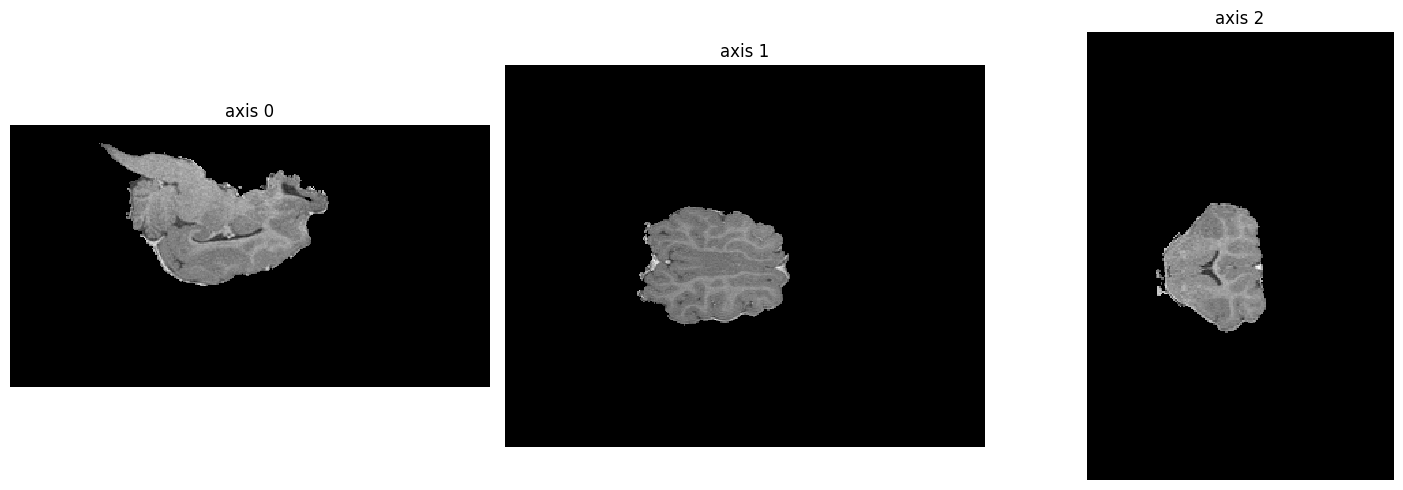

[DEBUG] NiftiArrayIO.load(): no header extensions found!


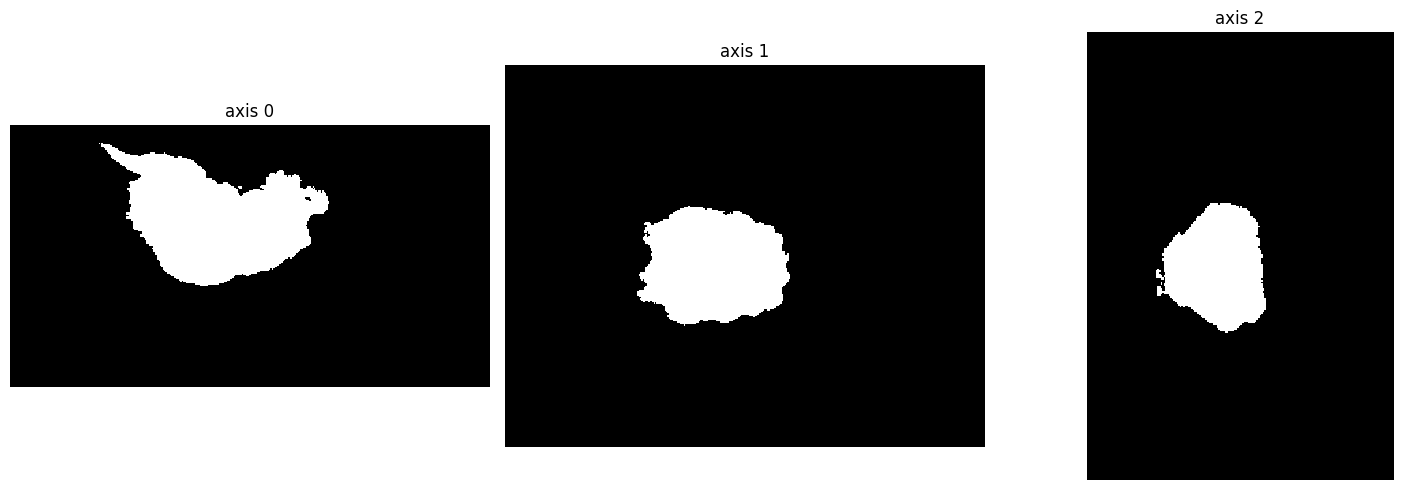

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [10]:
path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-082/JAW-082_T1_brain.nii.gz"
ne.plot.volume3D(sf.load_volume(str(path)))
path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-082/JAW-082_T1_mask.nii.gz"
ne.plot.volume3D(sf.load_volume(str(path)))

[DEBUG] NiftiArrayIO.load(): no header extensions found!


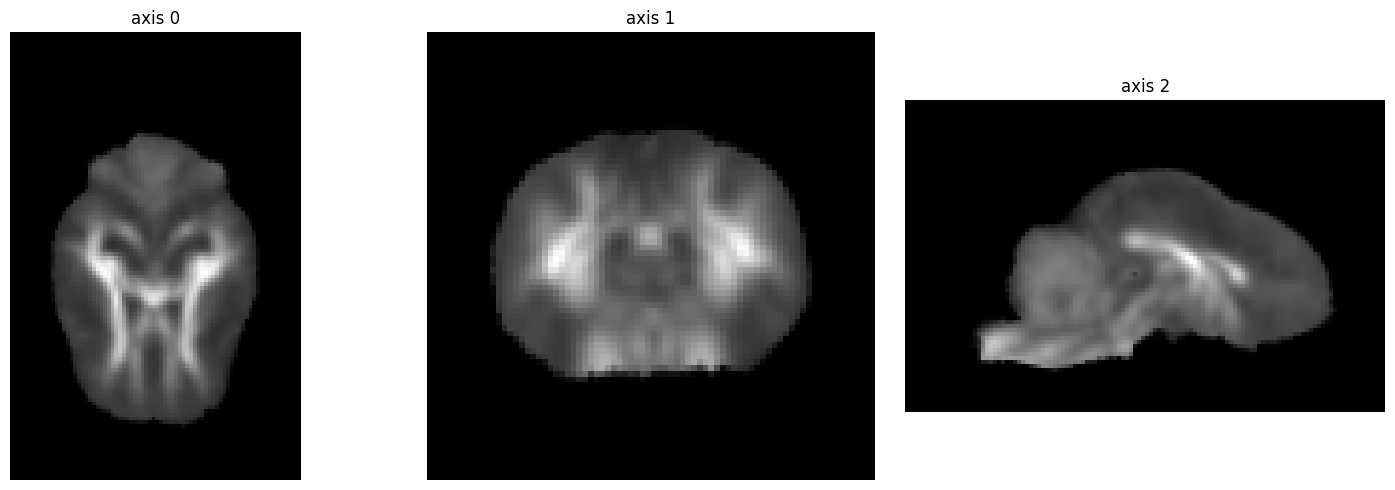

[DEBUG] NiftiArrayIO.load(): no header extensions found!


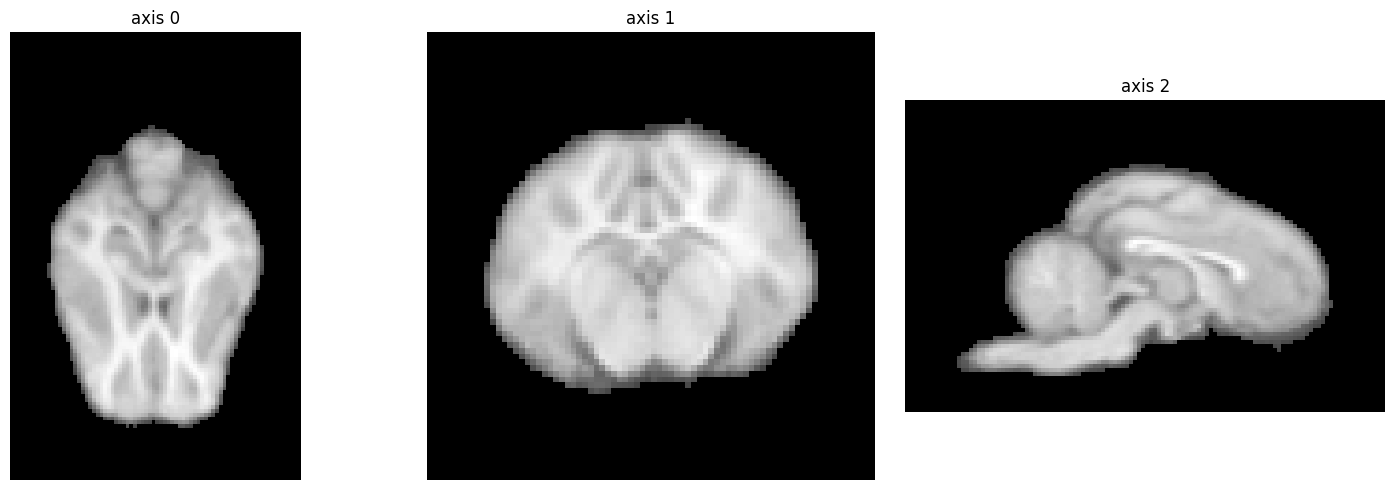

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [11]:
path = "/cbica/home/dadashkj/uiuc_pig_brain_atlas/v2.1_12wk_Atlas/Pig_FA_Standard_12wk.nii"
ne.plot.volume3D(sf.load_volume(str(path)))
path = "/cbica/home/dadashkj/uiuc_pig_brain_atlas/v2.1_12wk_Atlas/Pig_Brain_Atlas_12wk.nii"
pig_brain = sf.load_volume(str(path))
ne.plot.volume3D(pig_brain)

In [12]:
len(np.unique(pig_brain))

21804

[DEBUG] NiftiArrayIO.load(): no header extensions found!


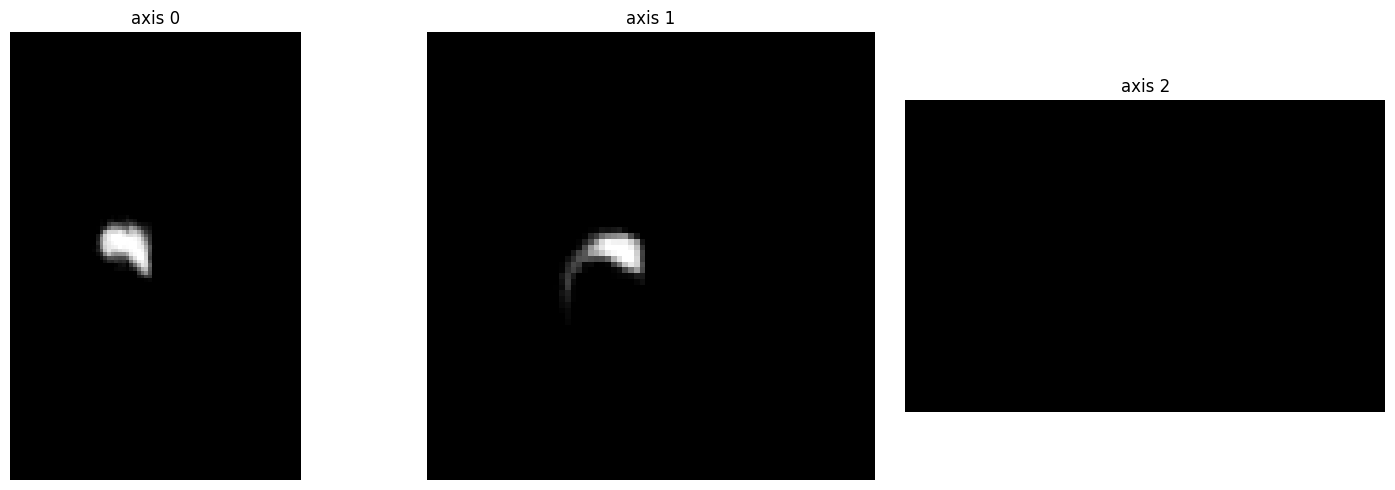

[DEBUG] NiftiArrayIO.load(): no header extensions found!


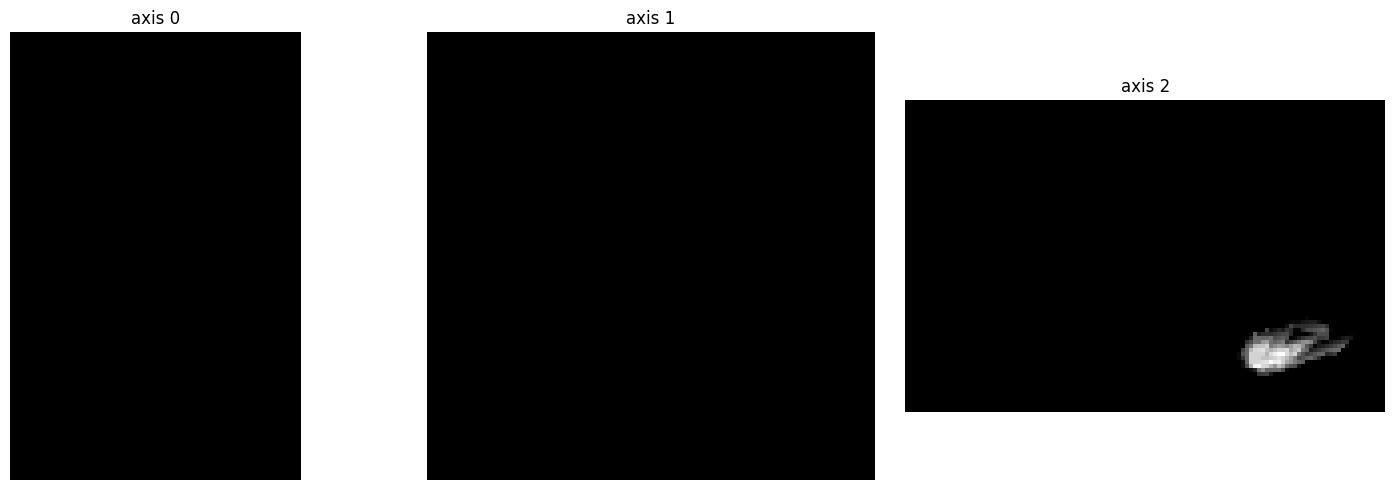

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [50]:
path = "/cbica/home/dadashkj/uiuc_pig_brain_atlas/v2.1_12wk_Atlas/Regions_of_Interest_12wk/ROI_thr0/Right_Hippocampus_thr0.nii"
pig_brain = sf.load_volume(str(path))
ne.plot.volume3D(pig_brain)
path = "/cbica/home/dadashkj/uiuc_pig_brain_atlas/v2.1_12wk_Atlas/Regions_of_Interest_12wk/ROI_thr0/Right_Olfactory_Bulb_thr0.nii"
pig_brain = sf.load_volume(str(path))
ne.plot.volume3D(pig_brain)

[DEBUG] NiftiArrayIO.load(): no header extensions found!


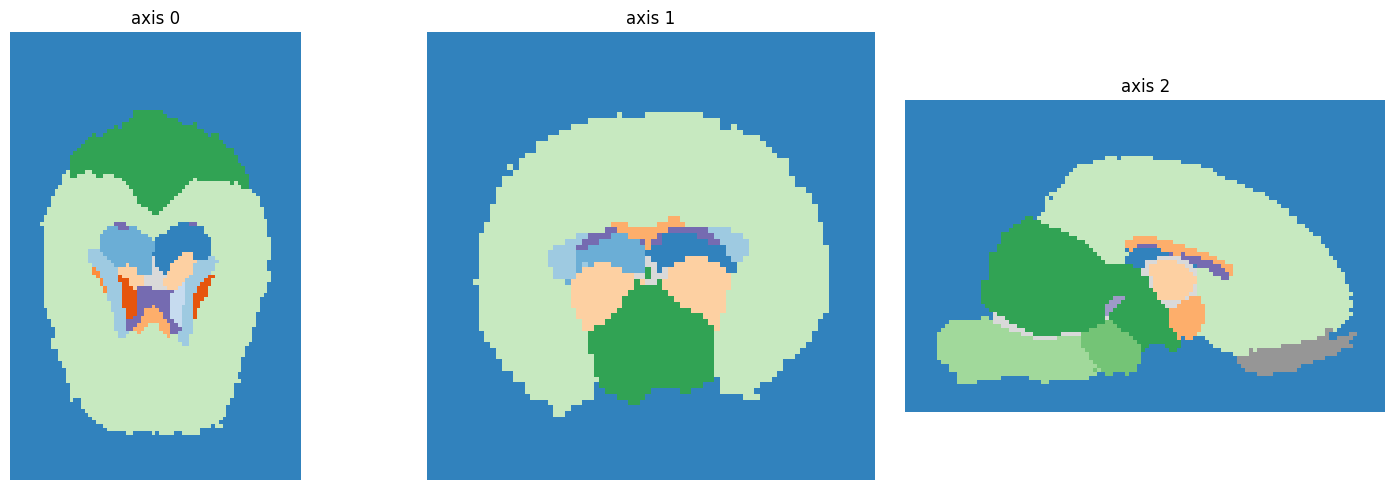

[DEBUG] NiftiArrayIO.load(): no header extensions found!


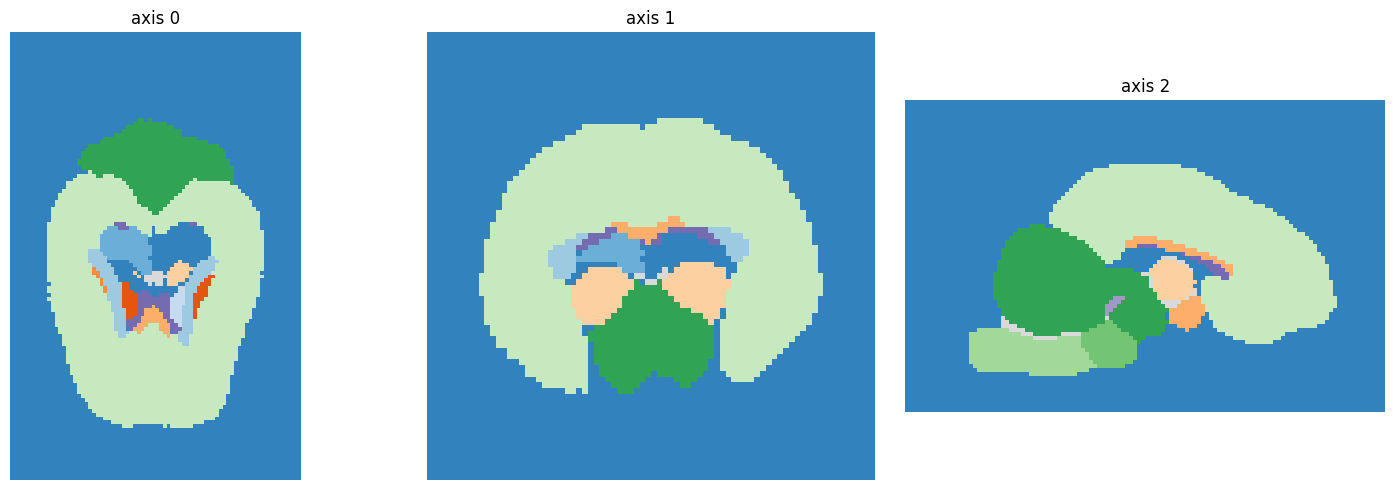

[DEBUG] NiftiArrayIO.load(): no header extensions found!


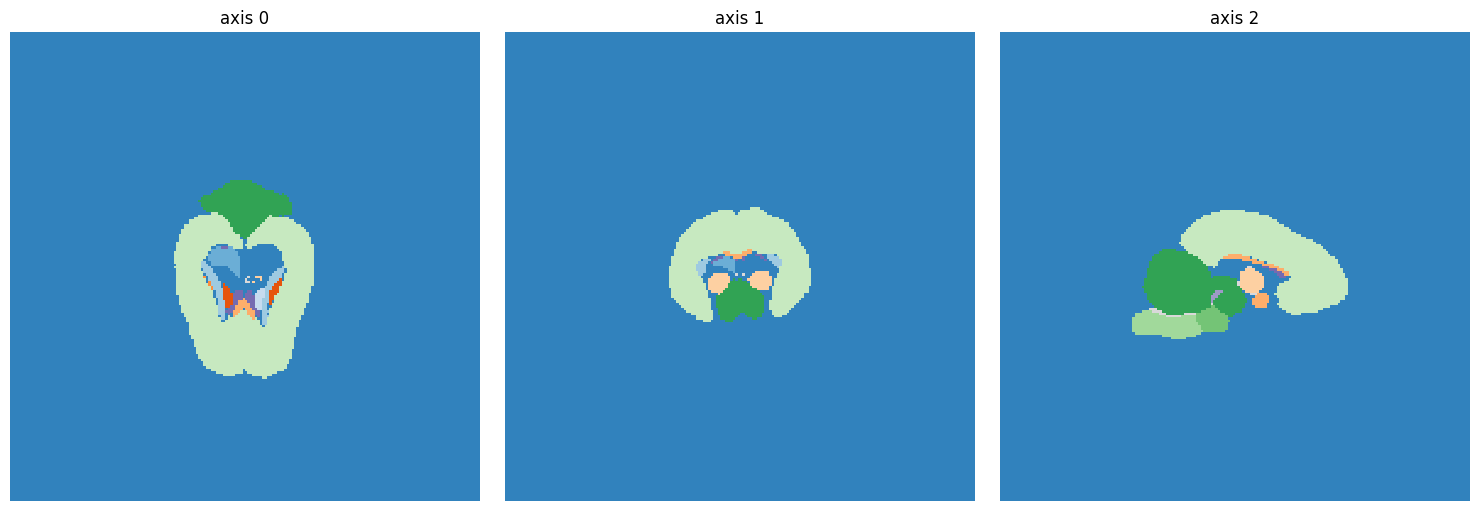

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 28. 29.]
[ 0 15] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 28. 29.]


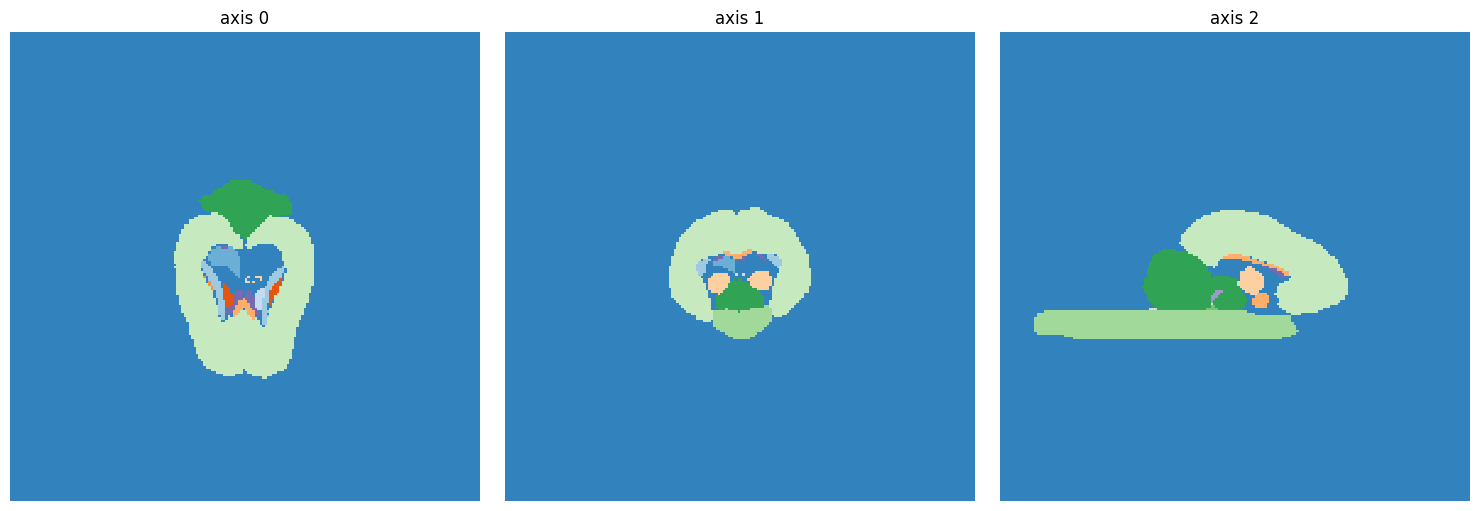

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 28. 29.]


In [2]:
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import binary_dilation

def extend_label_map_with_surfa(label_map, scale_factor=80, label_to_scale=15, img_size=[192, 192, 192]):
    label_data = np.array(label_map.data)
    label_area = (label_data == label_to_scale)
    label_data[label_data==15] = 0
    structure = np.ones((1, scale_factor, 1))
    label_area = binary_dilation(label_area, structure=structure)>0
    label_area = 15* label_area
    label_data = (label_area==0)*label_data + label_area
    print(np.unique(label_area),np.unique(label_data))
    return label_data

def dilate_label_map(label_map, structure=None):
    """
    Dilates all non-zero elements in a 3D label map.
    
    Parameters:
    - label_map (np.ndarray): 3D array representing the label map with integer values.
    - structure (np.ndarray, optional): A structuring element for dilation. If None, a 3x3x3 cube is used.

    Returns:
    - dilated_label_map (np.ndarray): Dilated 3D label map.
    """
    # Create a binary mask where non-zero elements are marked as True
    binary_mask = label_map > 0
    
    # Define default structuring element if not provided (3x3x3 cube)
    if structure is None:
        structure = np.ones((10, 10, 10), dtype=bool)
    
    # Apply binary dilation
    dilated_mask = binary_dilation(binary_mask, structure=structure)
    
    # Create the new label map with dilated regions
    dilated_label_map = label_map.copy()
    
    # Replace the dilated positions with the original labels
    dilated_label_map[dilated_mask] = label_map[dilated_mask]
    
    return dilated_label_map

path = "/cbica/home/dadashkj/uiuc_pig_brain_atlas/v2.1_12wk_Atlas/Combined_Maps_12wk/Combined_thr0_12wk.nii"
pig_brain = sf.load_volume(str(path))
ne.plot.volume3D(pig_brain,cmaps=['tab20c'])
path = "/cbica/home/dadashkj/uiuc_pig_brain_atlas/v2.1_12wk_Atlas/Combined_Maps_12wk/Combined_thr25_12wk.nii"
pig_brain = sf.load_volume(str(path))
ne.plot.volume3D(pig_brain,cmaps=['tab20c'])
path = "/cbica/home/dadashkj/uiuc_pig_brain_atlas/v2.1_12wk_Atlas/Combined_Maps_12wk/Combined_thr50_12wk.nii"
pig_brain = sf.load_volume(str(path)).reshape([param_3d.img_size_192,]*3).data
ne.plot.volume3D(pig_brain,cmaps=['tab20c'])
print(np.unique(pig_brain))

pig_brain = extend_label_map_with_surfa(pig_brain)
pig_brain = dilate_label_map(pig_brain)
ne.plot.volume3D(pig_brain,cmaps=['tab20c'])
print(np.unique(pig_brain))

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[ 0 15] [0.00000000e+00 1.66533454e-16 3.63797881e-11 ... 2.79999847e+01
 2.80000000e+01 2.89998894e+01]


2024-12-27 12:01:53.167689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11419 MB memory:  -> device: 0, name: TITAN Xp COLLECTORS EDITION, pci bus id: 0000:04:00.0, compute capability: 6.1
2024-12-27 12:02:06.666518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


(192, 192, 192, 1)
(192, 192, 192)


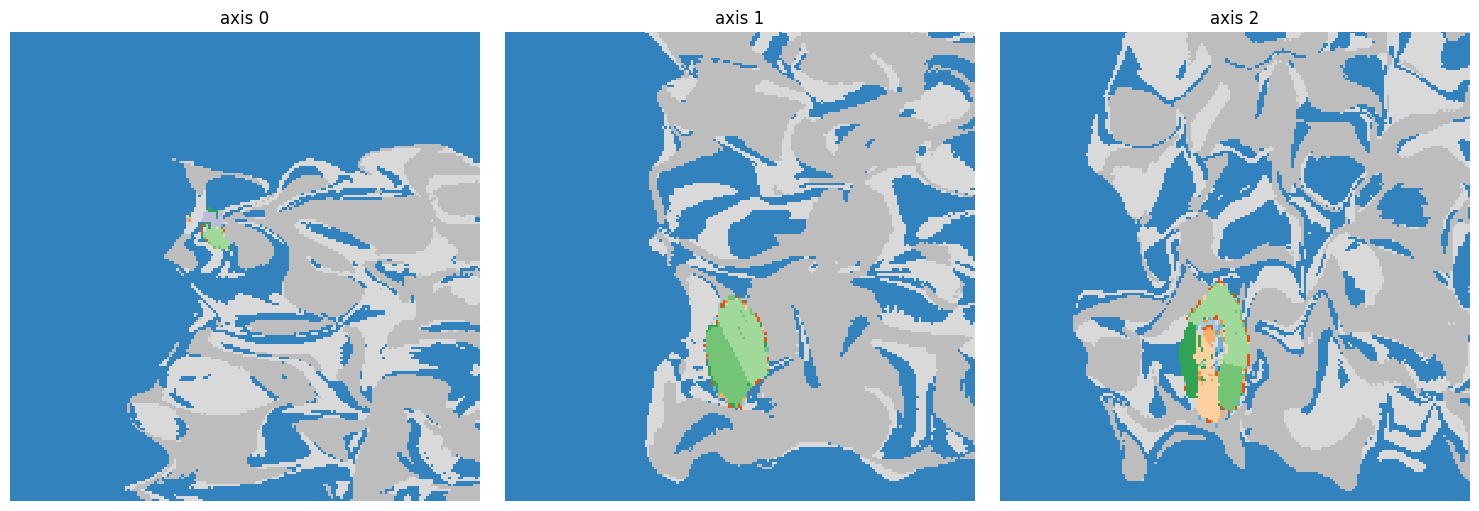

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [2]:
import pathlib
import json
import nibabel as nib
import numpy as np
import tensorflow as tf
from utils import *
import param_3d
import scipy.ndimage as ndimage
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message="model `labels_to_image` will switch from `ne.layers.Subsample` to `vxm.layers.DownUpSample` soon.")

path = "/cbica/home/dadashkj/uiuc_pig_brain_atlas/v2.1_12wk_Atlas/Combined_Maps_12wk/Combined_thr50_12wk.nii"
pig_brain = sf.load_volume(str(path)).resize(1.5).reshape([param_3d.img_size_192,]*3).data
pig_brain = extend_label_map_with_surfa(pig_brain,scale_factor=80)
pig_brain = dilate_label_map(pig_brain)
pig_brain_map = [pig_brain]

with open("params_192.json", "r") as json_file:
    config = json.load(json_file)

gen=generator_brain_window_Net(pig_brain_map,param_3d.img_size_192)



model_pig_config = config["pig_48"]
model_shapes_config = config["shapes"]
model3_config = config["labels_to_image_model_48"]
model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
model3_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]
model_pig_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]
model_shapes_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]

model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)

labels_to_image_model = create_model(model3_config)

shapes = draw_shapes_easy(shape = (param_3d.img_size_192,)*3)   
print(shapes.shape)
fragment = next(gen)
_, fg = model_pig(fragment)



shapes = tf.squeeze(shapes)
shapes = tf.cast(shapes, tf.uint8)
print(shapes.shape)
_, bg = model_shapes(shapes[None,...,None])
bg = shift_non_zero_elements(bg,29)    
result = fg + bg * tf.cast(fg == 0,tf.int32)
ne.plot.volume3D(result,cmaps=['tab20c'])

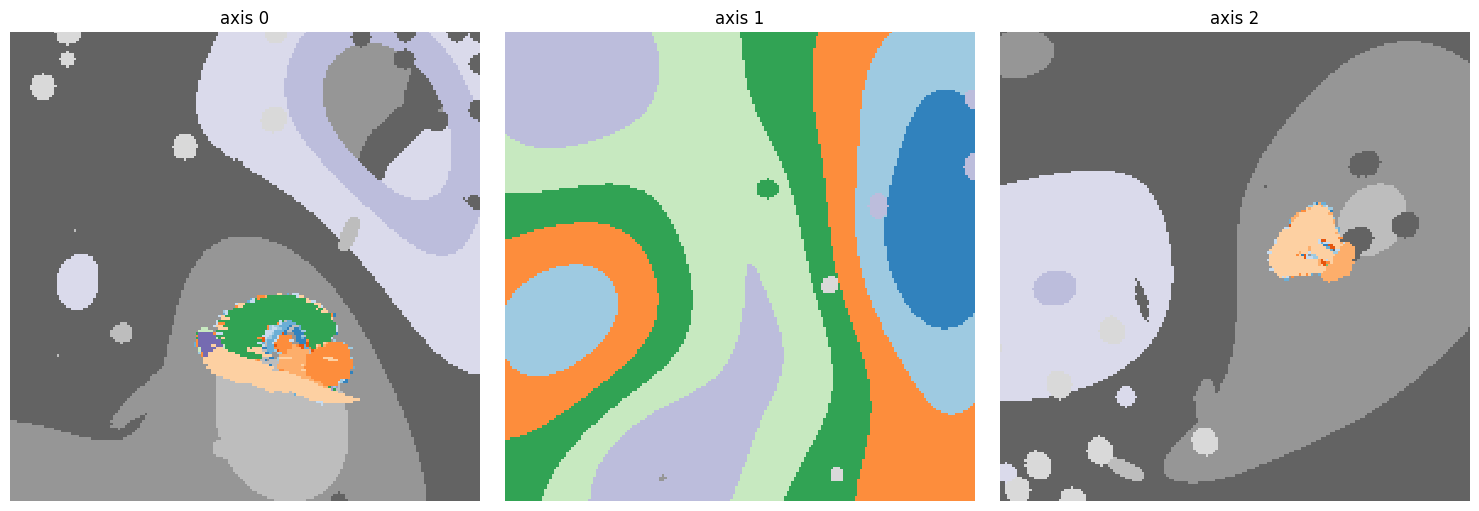

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [4]:
shapes = draw_shapes_easy(shape = (param_3d.img_size_192,)*3,num_label=10)

shapes = tf.squeeze(shapes)
shapes = tf.cast(shapes, tf.int32)

bones = draw_bones_only(shape = (param_3d.img_size_192,)*3,num_labels=16,num_bones=20)
bones = tf.cast(bones, tf.int32)
bones = shift_non_zero_elements(bones,29)

shapes2 = draw_layer_elipses(shape=(param_3d.img_size_192,)*3, num_labels=8, num_shapes=50, sigma=2)
shapes2 = tf.squeeze(shapes2)
shapes2 = tf.cast(shapes2, tf.int32)
shapes2 = shift_non_zero_elements(shapes2,29)  

shapes2 = bones + shapes2 * tf.cast(bones == 0,tf.int32)
result = fg[0,...,0] + shapes2 * tf.cast(fg[0,...,0] == 0,tf.int32)
ne.plot.volume3D(result,cmaps=['tab20c'])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30]


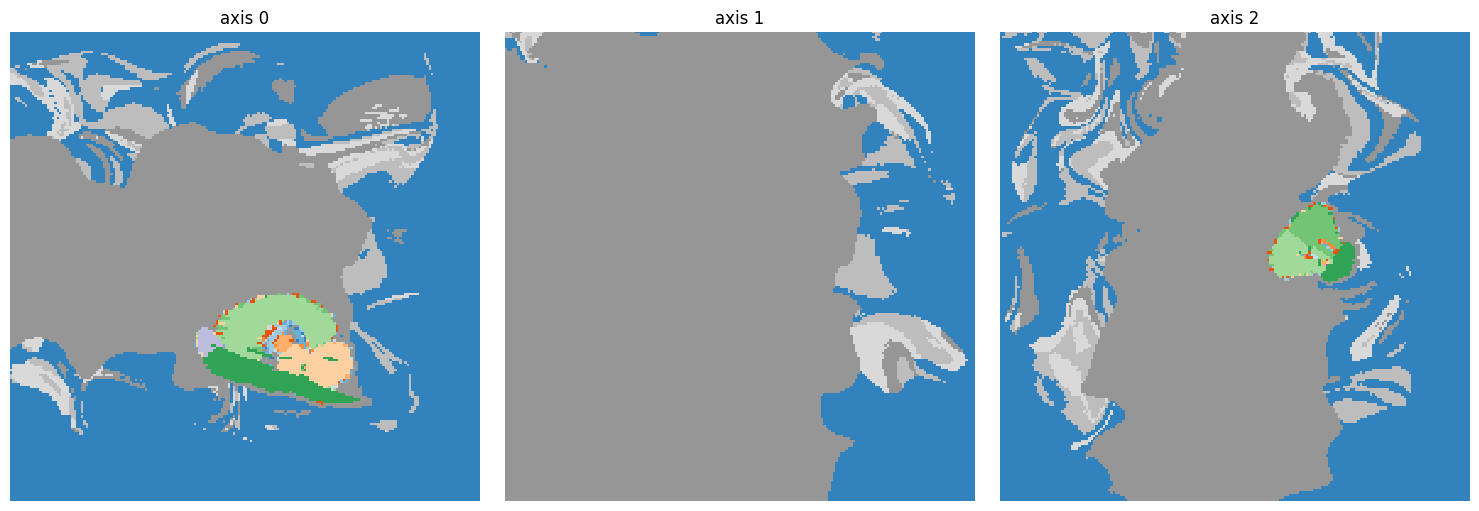

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [5]:
shapes = draw_shapes_easy(shape = (param_3d.img_size_192,)*3,num_label=10)

shapes = tf.squeeze(shapes)
shapes = tf.cast(shapes, tf.int32)

shapes2 = draw_shapes_easy(shape = (param_3d.img_size_192,)*3,num_label=10)
shapes2 = tf.squeeze(shapes2)
shapes2 = tf.cast(shapes2, tf.int32)

print(np.unique(fg))
wrapped_fg = wrap_with_label_tf(fg,thickness=1, iterations=1)
print(np.unique(wrapped_fg))
wrapped_fg = tf.cast(wrapped_fg,tf.int32)
elips = create_ellipsoid_around_brain(fg[0,...,0],margin=10)

elips = shift_non_zero_elements(elips,29) 
elips = tf.cast(elips,tf.int32)
elips = wrap_with_label_tf(elips[None,...,None],thickness=1, iterations=1)
elips = elips[0,...,0]
elips = tf.cast(elips,tf.int32)

elips = elips +  shapes* tf.cast(elips == 31,tf.int32)

_, elips = model_shapes(elips[None,...,None])
elips = elips[0,...,0]
_, bg = model_shapes(shapes[None,...,None])
bg = shift_non_zero_elements(bg,29)  

combined_with_elips = wrapped_fg[0,...,0] +  elips* tf.cast(wrapped_fg[0,...,0] == 0,tf.int32)
result = combined_with_elips + bg[0,...,0] * tf.cast(combined_with_elips == 0,tf.int32)
ne.plot.volume3D(result,cmaps=['tab20c'])

(1, 192, 192, 192, 1)


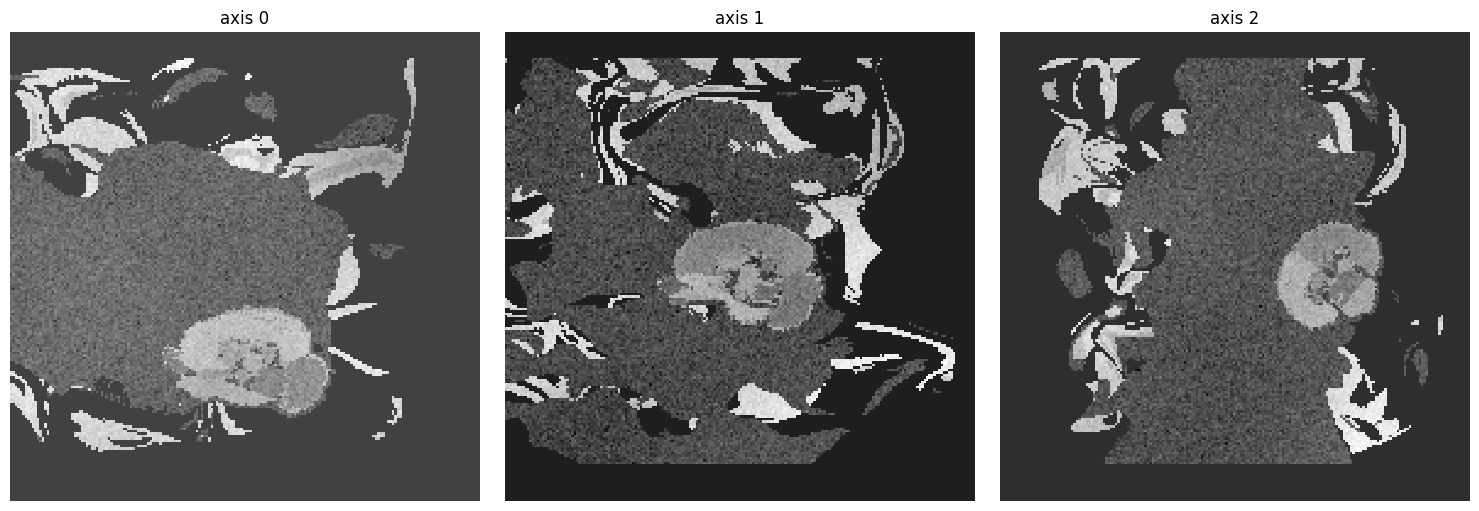

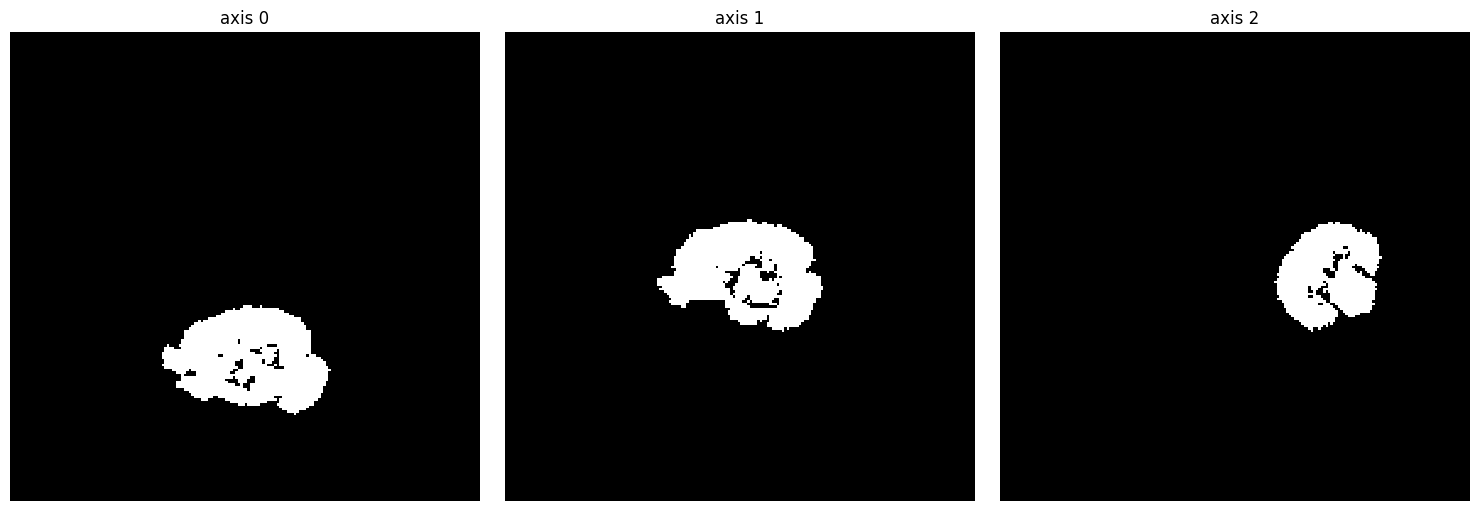

(1, 192, 192, 192, 1)


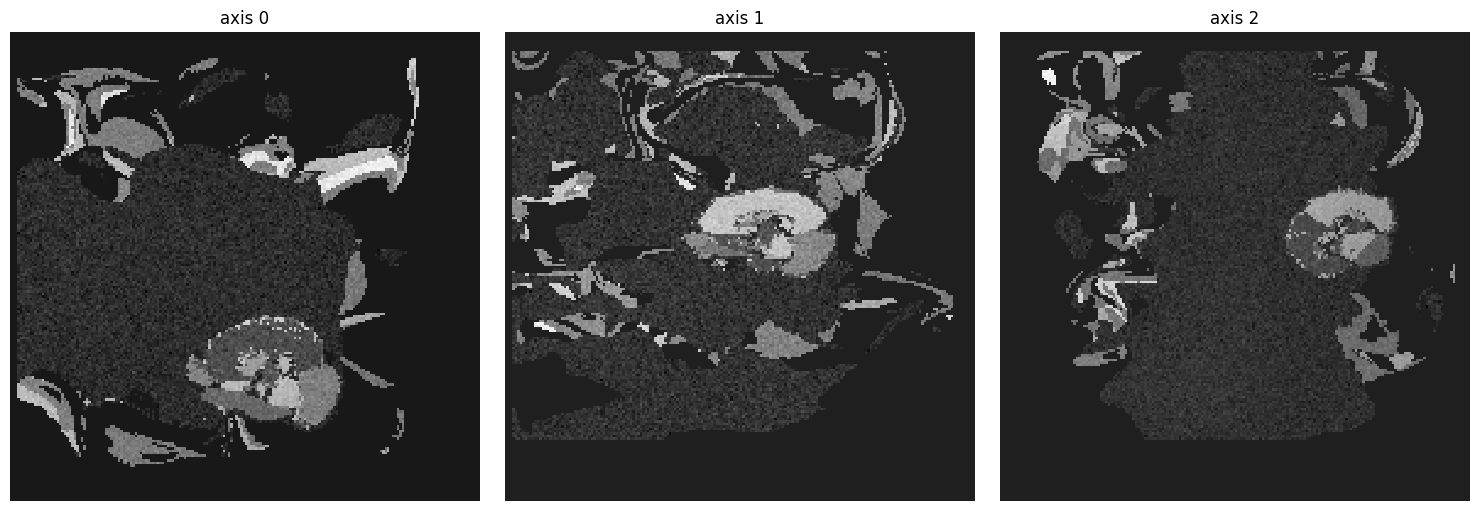

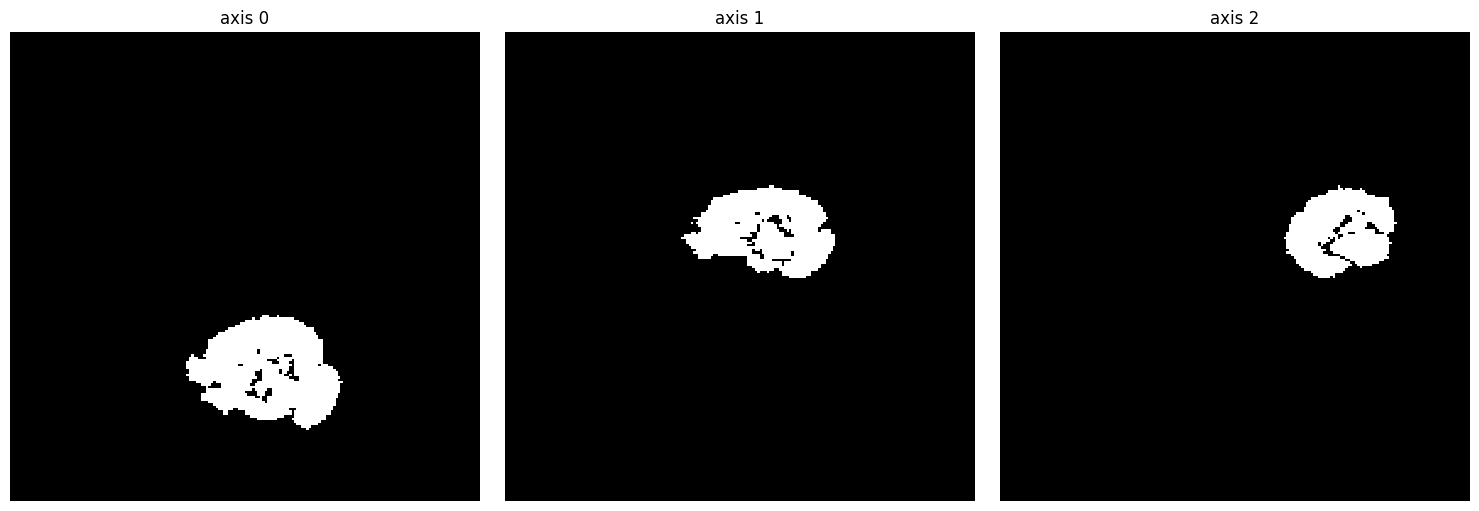

(1, 192, 192, 192, 1)


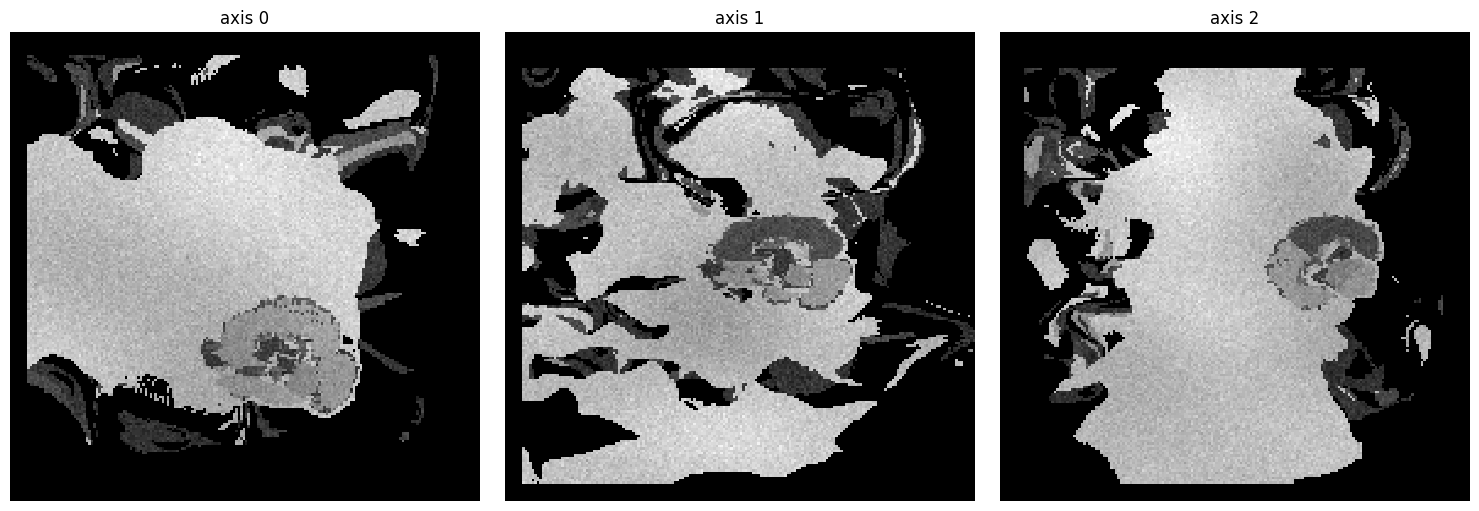

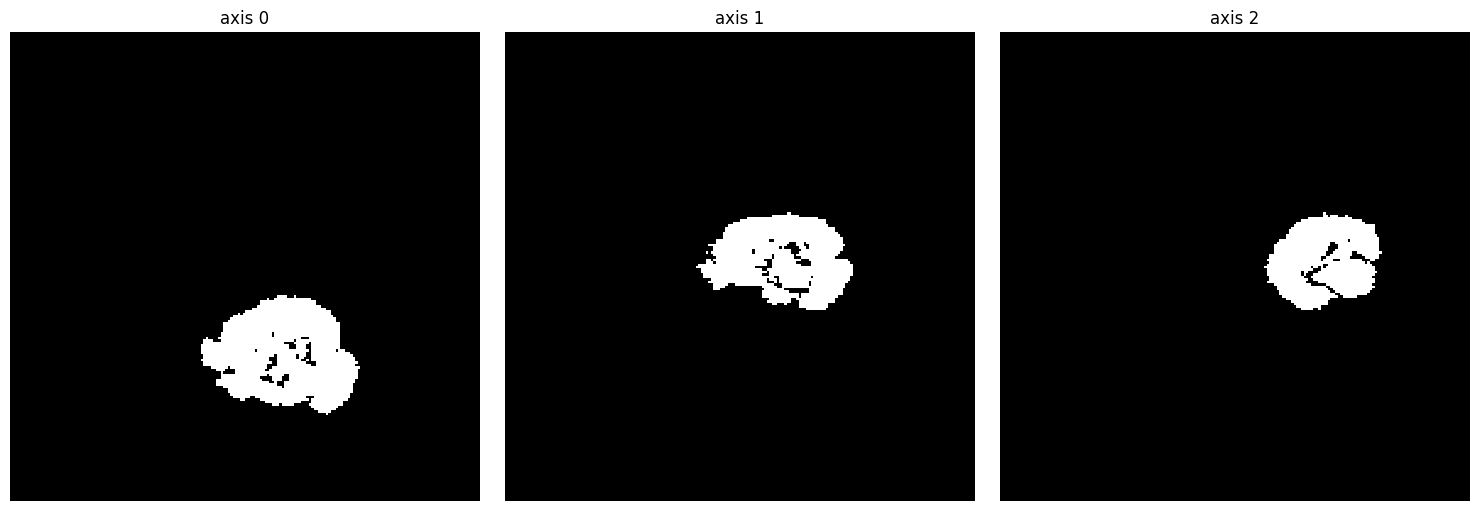

(1, 192, 192, 192, 1)


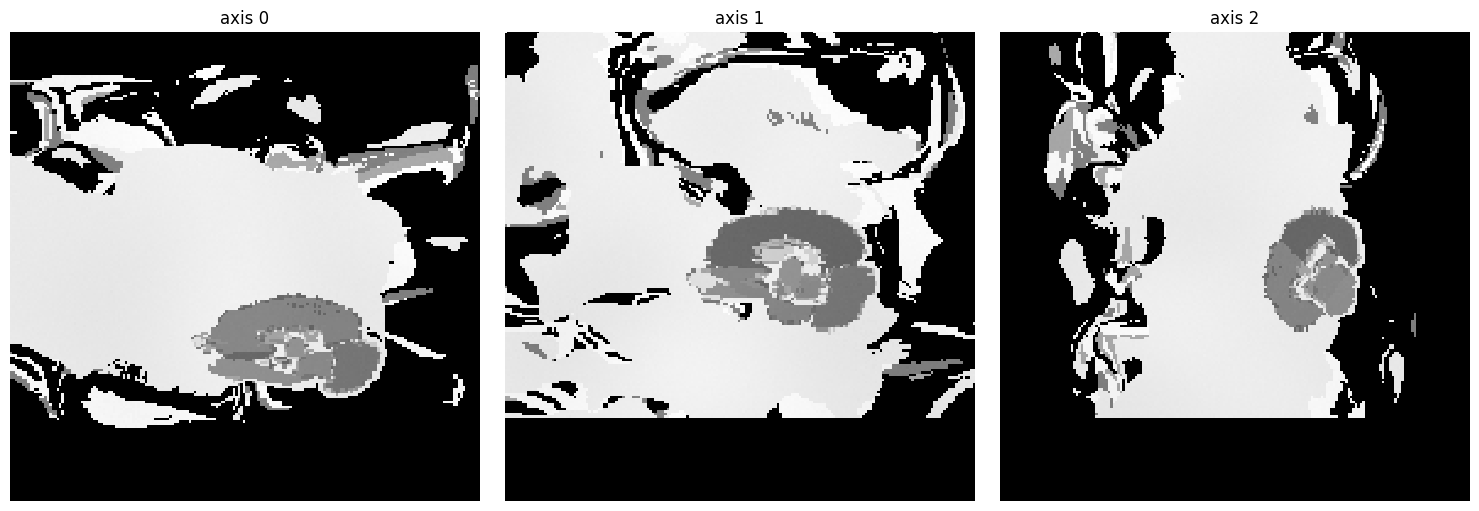

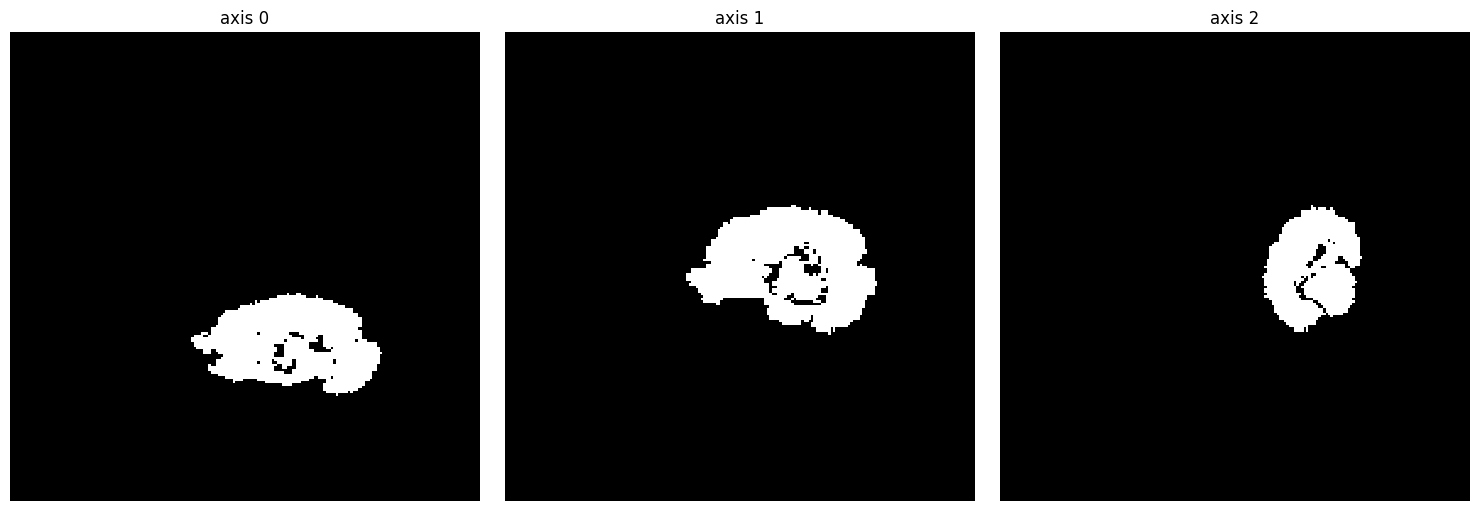

(1, 192, 192, 192, 1)


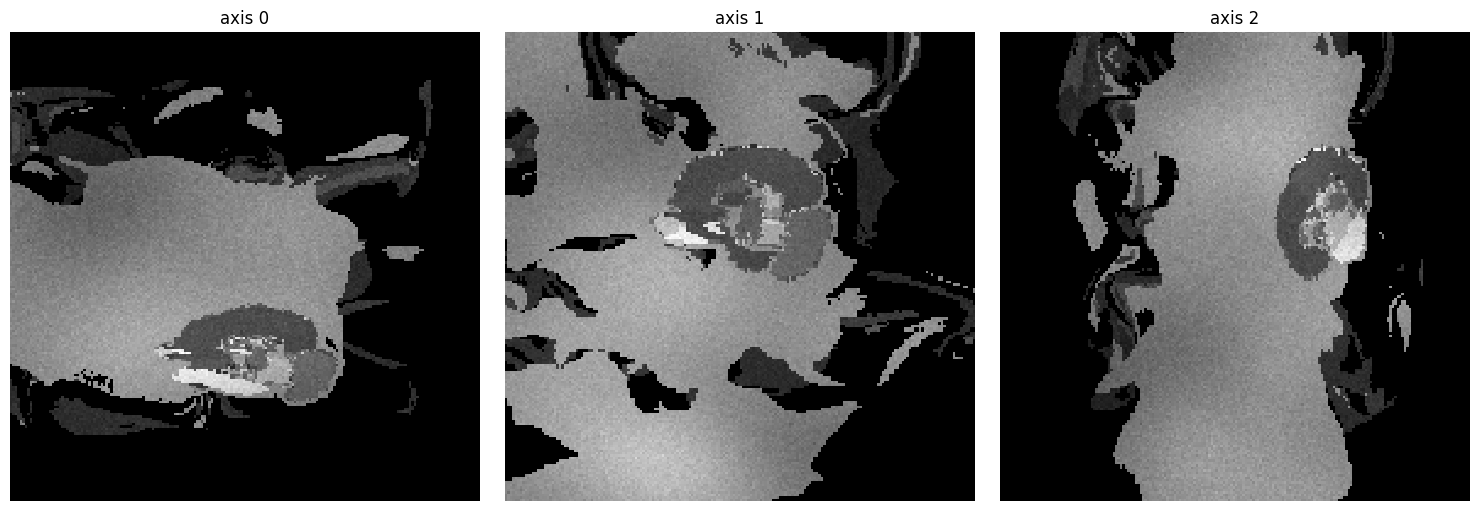

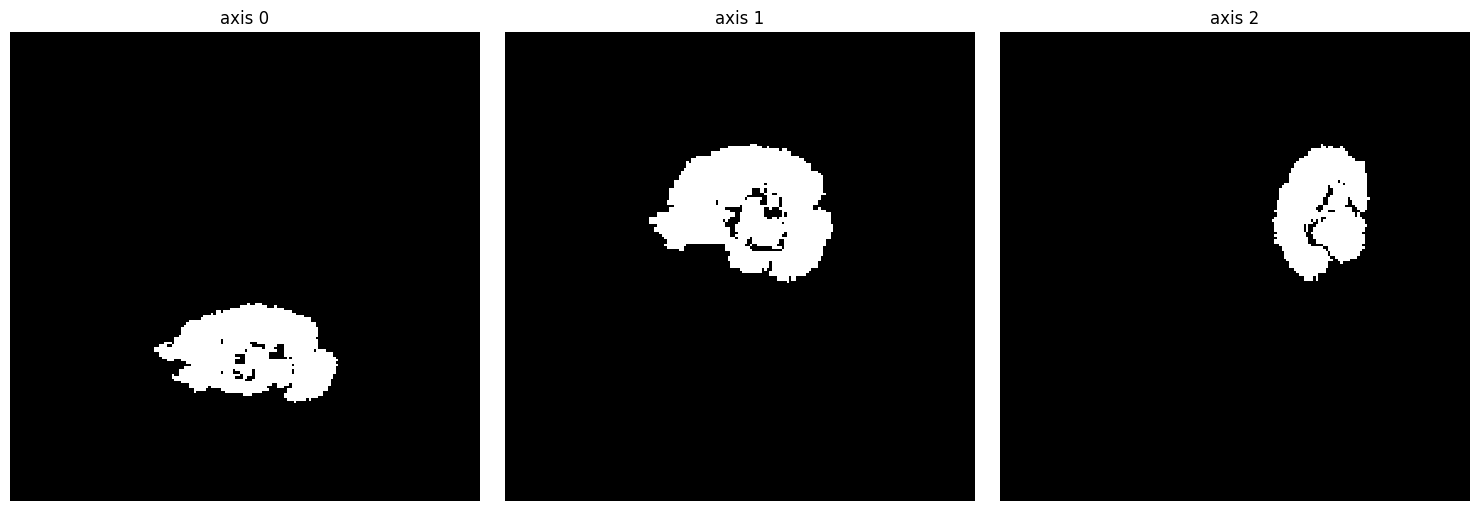

In [6]:
for i in range(5):
    labels_to_image_model = create_model(model3_config)
    generated_img, y = labels_to_image_model(result[None,...,])
    
    print(generated_img.shape)
    z=np.argmax(y,axis=-1)
    ms = np.mean(np.column_stack(np.nonzero(z[0])), axis=0).astype(int)
    
    ne.plot.volume3D(generated_img,slice_nos=ms);
    ne.plot.volume3D(np.argmax(y,axis=-1),slice_nos=ms);

In [7]:
!ls -R /gpfs/fs001/cbica/external/software

ls: cannot access /gpfs/fs001/cbica/external/software: No such file or directory


In [8]:
!pwd

/cbica/home/dadashkj/decipher


In [4]:
from tensorflow.keras.layers import Input
input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192,1))

In [ ]:
pig_mask = tf.reduce_any(tf.equal(input_img, tf.cast(tf.constant([0, 1, 2, 3, 4, 5], dtype=tf.int32), tf.float32)), axis=-1, keepdims=True)
shapes_mask = tf.reduce_any(tf.equal(input_img, tf.cast(tf.constant([0, 6, 7, 8, 9], dtype=tf.int32), tf.float32)), axis=-1, keepdims=True)